In [10]:
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import time
from torch import nn
from skimage.io import imshow
%matplotlib inline
from torch.nn import functional as F
import torch.utils.data
from torchvision.models.inception import inception_v3

from interpolation import vicinity_sampling

In [4]:
dimZ = 100

# define the network
# you can start from https://github.com/pytorch/examples/blob/master/vae/main.py
# or Theano-based examples here https://github.com/Lasagne/Recipes/blob/master/examples/variational_autoencoder/variational_autoencoder.py
# and here https://github.com/y0ast/Variational-Autoencoder/blob/master/VAE.py
# but remember that this is not your ground truth since the data is not MNIST

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        #encoder
        self.encoder = nn.Sequential(
            nn.Linear(6075, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 2*dimZ))
        
        #decoder
        self.decoder = nn.Sequential(
            nn.Linear(dimZ, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 6075 * 2)
        )
        self.s = nn.Sigmoid()
    def gaussian_sampler(self, mu, logsigma):
        #print(mu.size(), logsigma.size())
        if self.training:
            std = logsigma.exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def encode(self, x):
        combined = self.encoder(x)
        return combined[:, :dimZ], combined[:, dimZ:]
        
    def decode(self, x):
        combined = self.decoder(x)
        return self.s(combined[:, :6075]), combined[:, 6075:]
        
    def forward(self, x):
        latent_mu, latent_logsigma = self.encode(x)
        samples = self.gaussian_sampler(latent_mu, latent_logsigma)
        reconstruction_mu, reconstruction_logsigma = self.decode(samples)
        return reconstruction_mu, reconstruction_logsigma, latent_mu, latent_logsigma


In [5]:
net_VAE = VAE().to('cpu')
net_VAE.load_state_dict(torch.load('VAE-deepfunneled/weights-vae-deepfunneled', map_location='cpu'))
net_VAE.eval()

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=6075, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=200, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=1024, bias=True)
    (4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=1024, out_features=12150, bias=True)
  )
  (s): Sigmoid()
)

In [5]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())

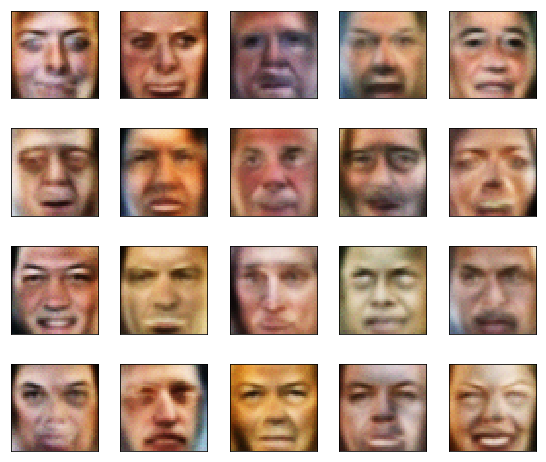

In [6]:
vae=net_VAE
samples = torch.randn(20, dimZ, requires_grad=True)
decoder_mu = vae.decode(samples)[0]
image_h = 45
image_w = 45
plot_gallery(decoder_mu.data.cpu().numpy(), image_h, image_w, n_row=4, n_col=5)

## 2 point interpolation

In [12]:
def plot_torch_picture(tensor, ax=None):
    if ax is None:
        plt.imshow(tensor.detach().data.numpy().reshape((45,45,3)))
        plt.axis('off')
        plt.show()
    else:
        ax.axis('off')
        ax.imshow(tensor.detach().data.numpy().reshape((45,45,3)))

In [9]:
Image_set = np.load('X_val.npy')

In [43]:
def interpolation_sequence_generation(list_t):
    
    img_1 = Image_set[np.random.randint(Image_set.shape[0])].copy()
    img_2 = Image_set[np.random.randint(Image_set.shape[0])].copy()
    
    fig, axs = plt.subplots(nrows=2, ncols=len(list_t)+4, sharex=True,figsize = (20,5))
    
    axs[0,0].imshow(img_1, cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
    axs[0,len(list_t)+3].imshow(img_2, cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
    axs[1,0].imshow(img_1, cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
    axs[1,len(list_t)+3].imshow(img_2, cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
    axs[0,0].axis('off')
    axs[0,len(list_t)+3].axis('off')
    axs[1,0].axis('off')
    axs[1,len(list_t)+3].axis('off')
    img_1 = np.float32(img_1)
    img_1 = img_1 / 255
    img_1 = img_1.reshape(1,-1)
    tensor_1 = torch.tensor(img_1)
    
    img_2 = np.float32(img_2)
    img_2 = img_2 / 255
    img_2 = img_2.reshape(1,-1)
    tensor_2 = torch.tensor(img_2)
    
    rand1, _ = net_VAE.encode(tensor_1)
    rand2, _ = net_VAE.encode(tensor_2)
    rand1 = rand1.detach()
    rand2 = rand2.detach()
    
    interpolation_ot =[]
    interpolation_no_scale = []
    for t in reversed(list_t):
        interpolation_ot.append(two_point_interpolation(rand1, rand2, t=t, do_scale=True))
        interpolation_no_scale.append(two_point_interpolation(rand1, rand2,t = t, do_scale=False))
    
    output1 = net_VAE.decode(rand1)[0]
    output2 = net_VAE.decode(rand2)[0]

    plot_torch_picture(output1, ax = axs[0,1])
    plot_torch_picture(output2, ax = axs[0,len(list_t)+2])
    plot_torch_picture(output1, ax = axs[1,1])
    plot_torch_picture(output2, ax = axs[1,len(list_t)+2])
    for i in range(len(list_t)):
        plot_torch_picture(net_VAE.decode(interpolation_ot[i])[0], ax = axs[0,i+2])
        plot_torch_picture(net_VAE.decode(interpolation_no_scale[i])[0], ax = axs[1,i+2])

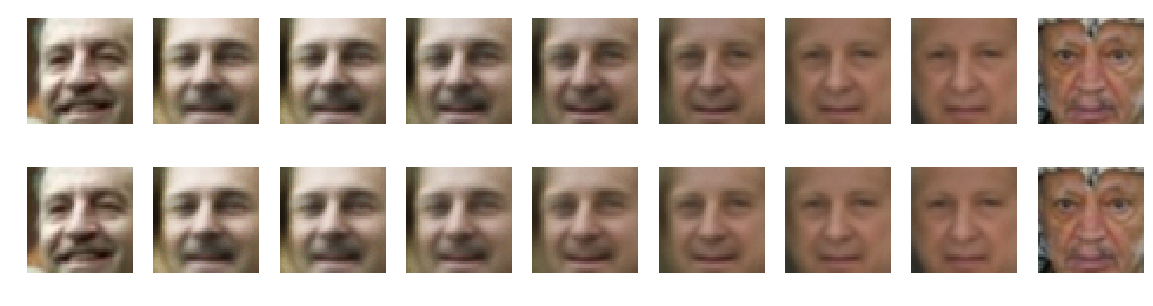

In [46]:
list_t = np.linspace(0.1, 0.9, 5)

interpolation_sequence_generation(list_t)

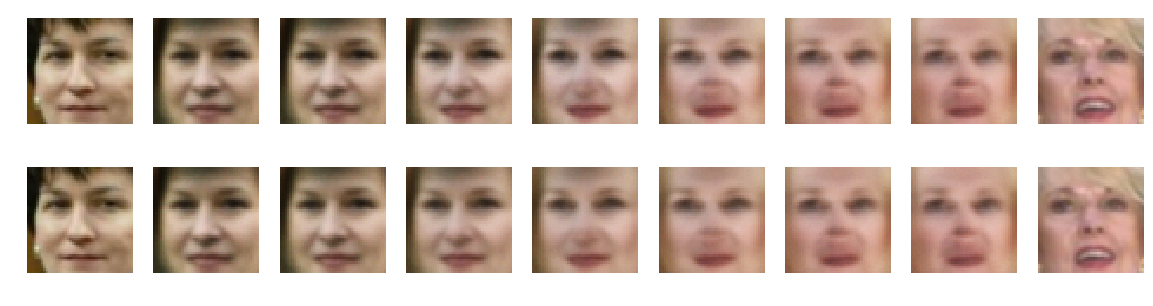

In [49]:
interpolation_sequence_generation(list_t)

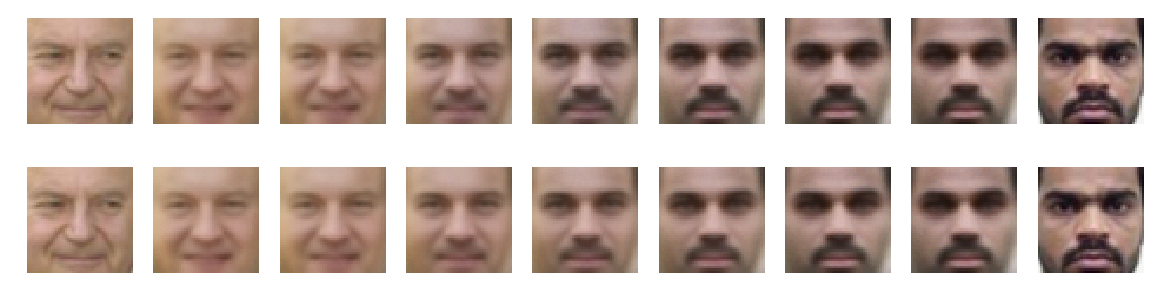

In [50]:
interpolation_sequence_generation(list_t)

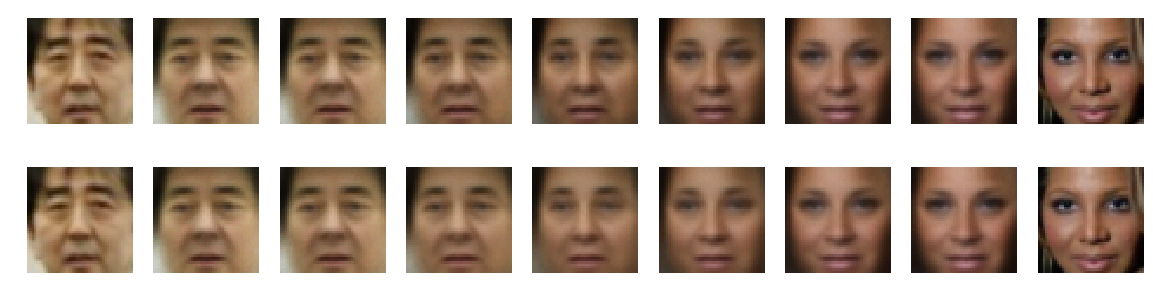

In [54]:
interpolation_sequence_generation(list_t)

### 4 point interpolation

In [63]:
def n_point_interpolation(tensors, coef_tensor, do_scale=False):
    assert coef_tensor.sum(0) == 1
    scaling_factor = (coef_tensor**2).sum(0)**0.5
    resulting_tensor = (coef_tensor.unsqueeze(1) * tensors).sum(0).view(1,100)
    if do_scale:
        return resulting_tensor / scaling_factor
    else:
        return resulting_tensor

In [64]:
coefficients = [[[1,0,0,0],[3/4,0,0,1/4],[1/2,0,0,1/2],[1/4,0,0,3/4],[0,0,0,1]],
               [[3/4,1/4,0,0],[1/2,1/4,0,1/4],[1/4,1/4,0,1/2],[0,1/4,0,3/4],[0,0,1/4,3/4]],
               [[1/2,1/2,0,0],[1/4,1/2,0,1/4],[1/4,1/4,1/4,1/4],[1/4,0,1/4,1/2],[0,0,1/2,1/2]],
               [[1/4,3/4,0,0],[1/4,1/2,0,1/4],[1/4,1/2,0,1/4],[0,1/4,1/2,1/4],[0,0,3/4,1/4]],
               [[0,1,0,0],[0,3/4,1/4,0],[0,1/2,1/2,0],[0,1/4,3/4,0],[0,0,1,0]]]
coefficients = torch.tensor(coefficients)

In [67]:
def interpolation_4_generation():
    img_1 = Image_set[np.random.randint(Image_set.shape[0])].copy()
    img_2 = Image_set[np.random.randint(Image_set.shape[0])].copy()
    img_3 = Image_set[np.random.randint(Image_set.shape[0])].copy()
    img_4 = Image_set[np.random.randint(Image_set.shape[0])].copy()
    
    tensor_1 = torch.tensor((np.float32(img_1) / 255).reshape(1,-1))
    tensor_2 = torch.tensor((np.float32(img_2) / 255).reshape(1,-1))
    tensor_3 = torch.tensor((np.float32(img_3) / 255).reshape(1,-1))
    tensor_4 = torch.tensor((np.float32(img_4) / 255).reshape(1,-1))

    rand1= net_VAE.encode(tensor_1)[0].detach().view(100)
    rand2= net_VAE.encode(tensor_1)[0].detach().view(100)
    rand3= net_VAE.encode(tensor_1)[0].detach().view(100)
    rand4= net_VAE.encode(tensor_1)[0].detach().view(100)
    
    R = torch.stack([rand1, rand2, rand3, rand4])
    fig, axs = plt.subplots(nrows=5, ncols=10, sharex=True,figsize = (50,25))
    for i in range(5):
        for j in range(5):
            plot_torch_picture(net_VAE.decode(
                n_point_interpolation(R, coefficients[i,j], do_scale=True))[0], ax = axs[i,j]) 
            plot_torch_picture(net_VAE.decode(
                n_point_interpolation(R, coefficients[i,j], do_scale=False))[0], ax = axs[i,j+5])

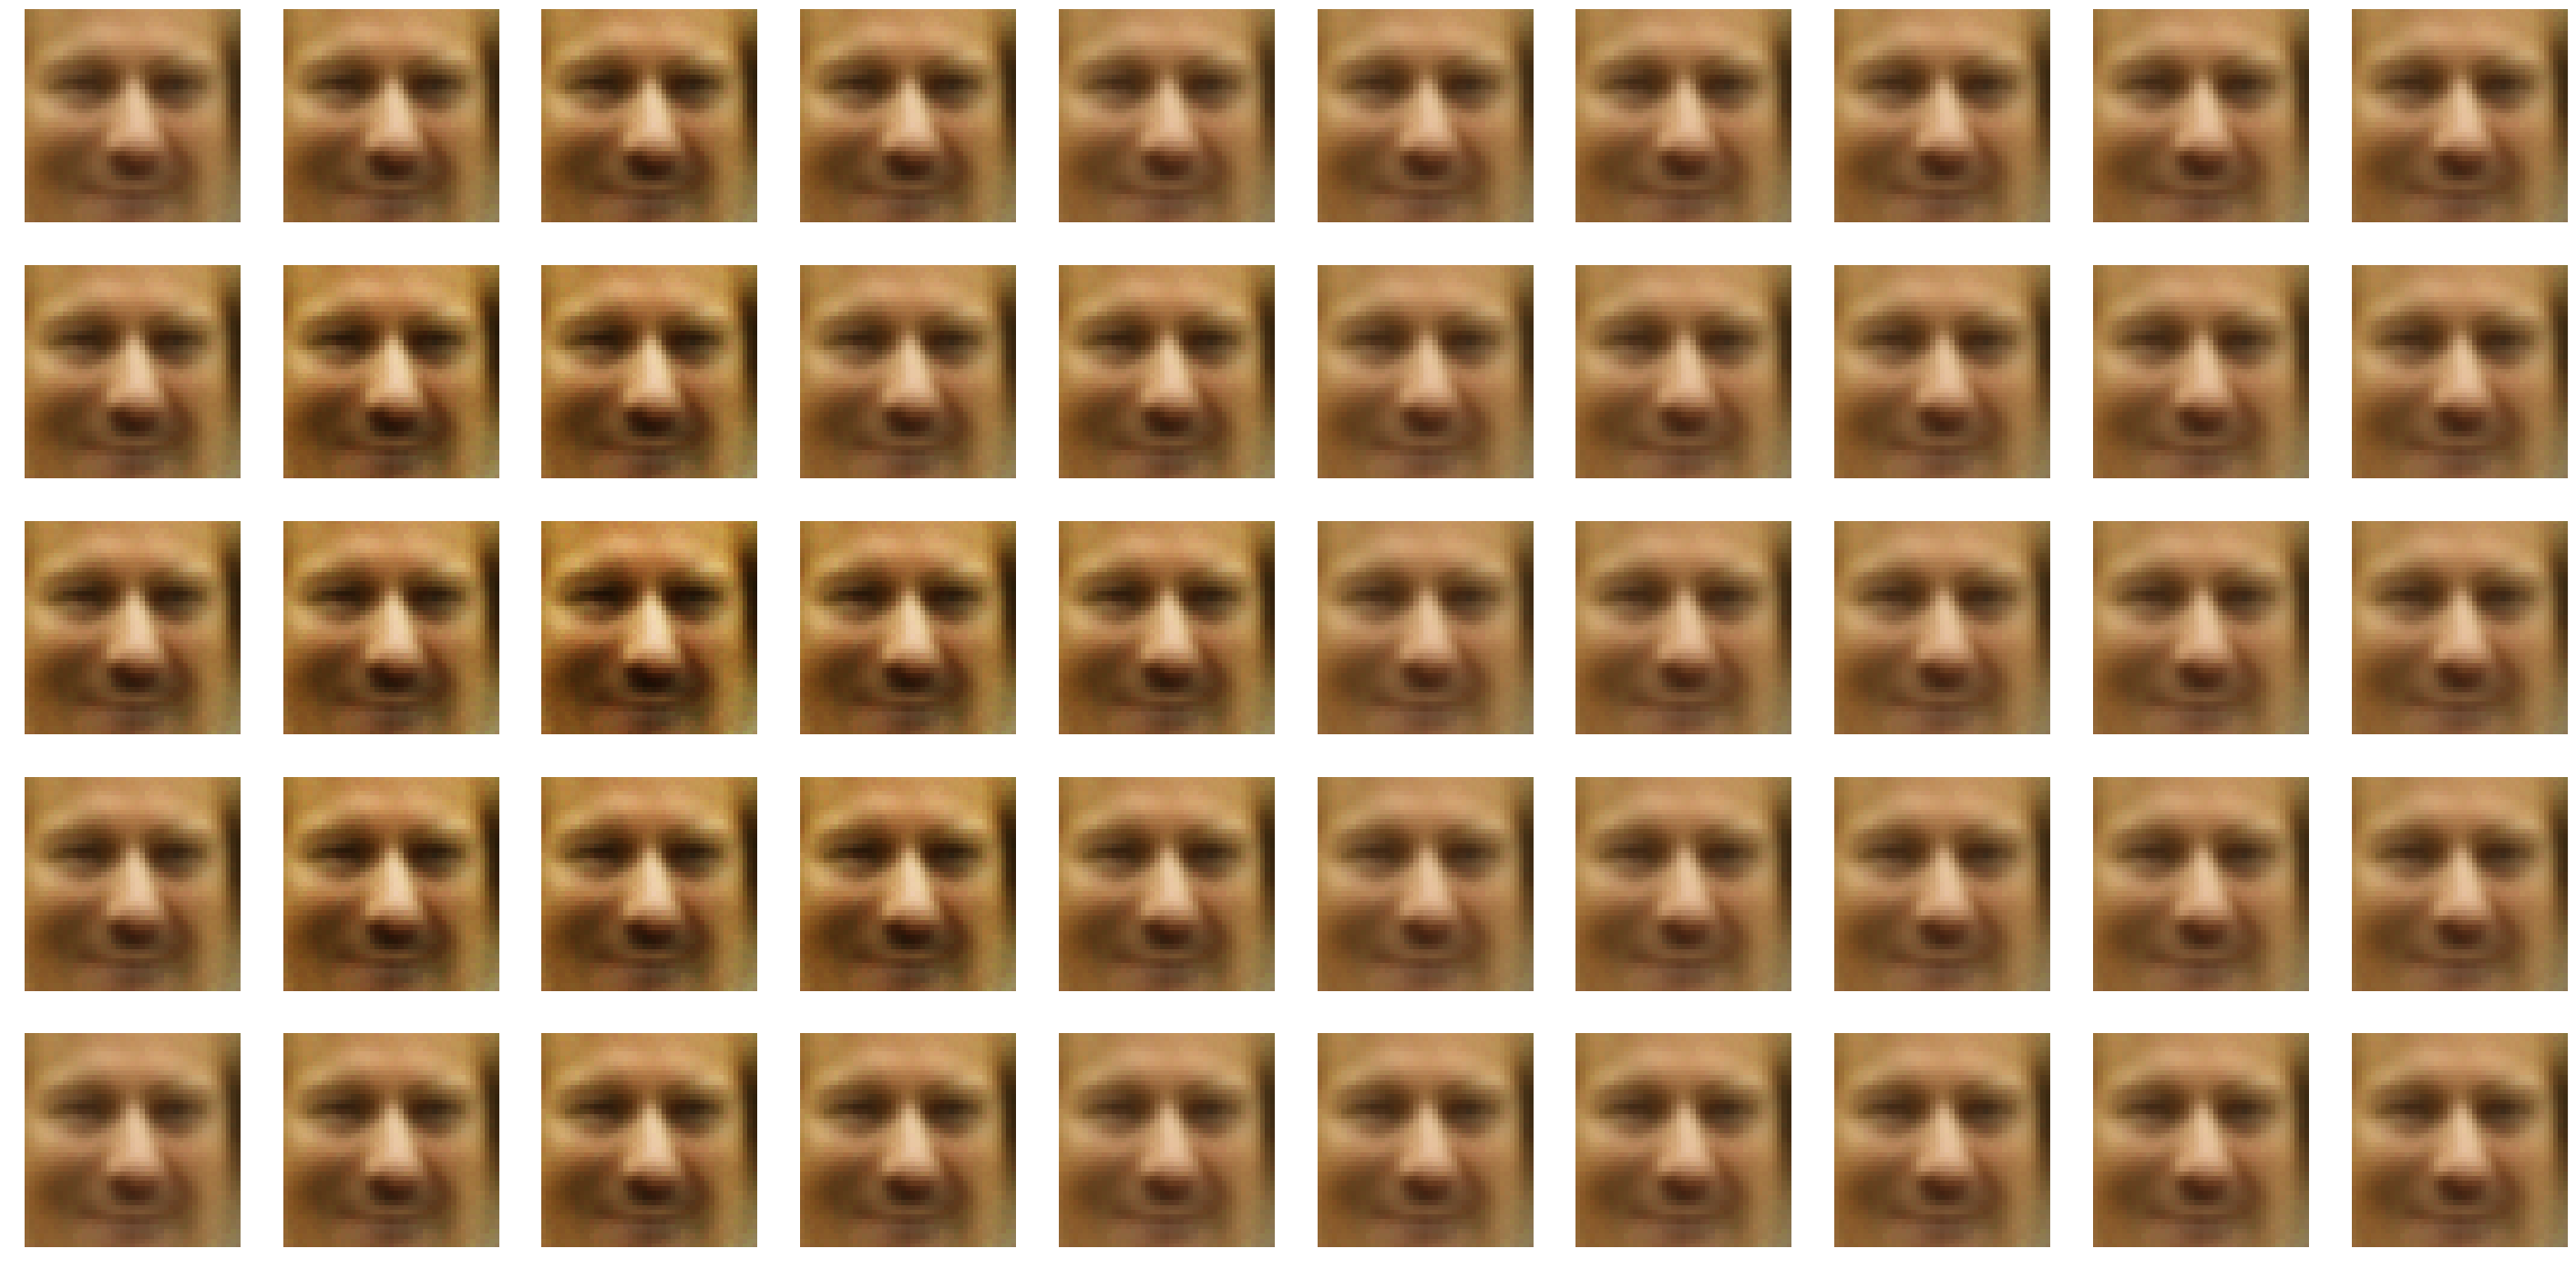

In [68]:
interpolation_4_generation()

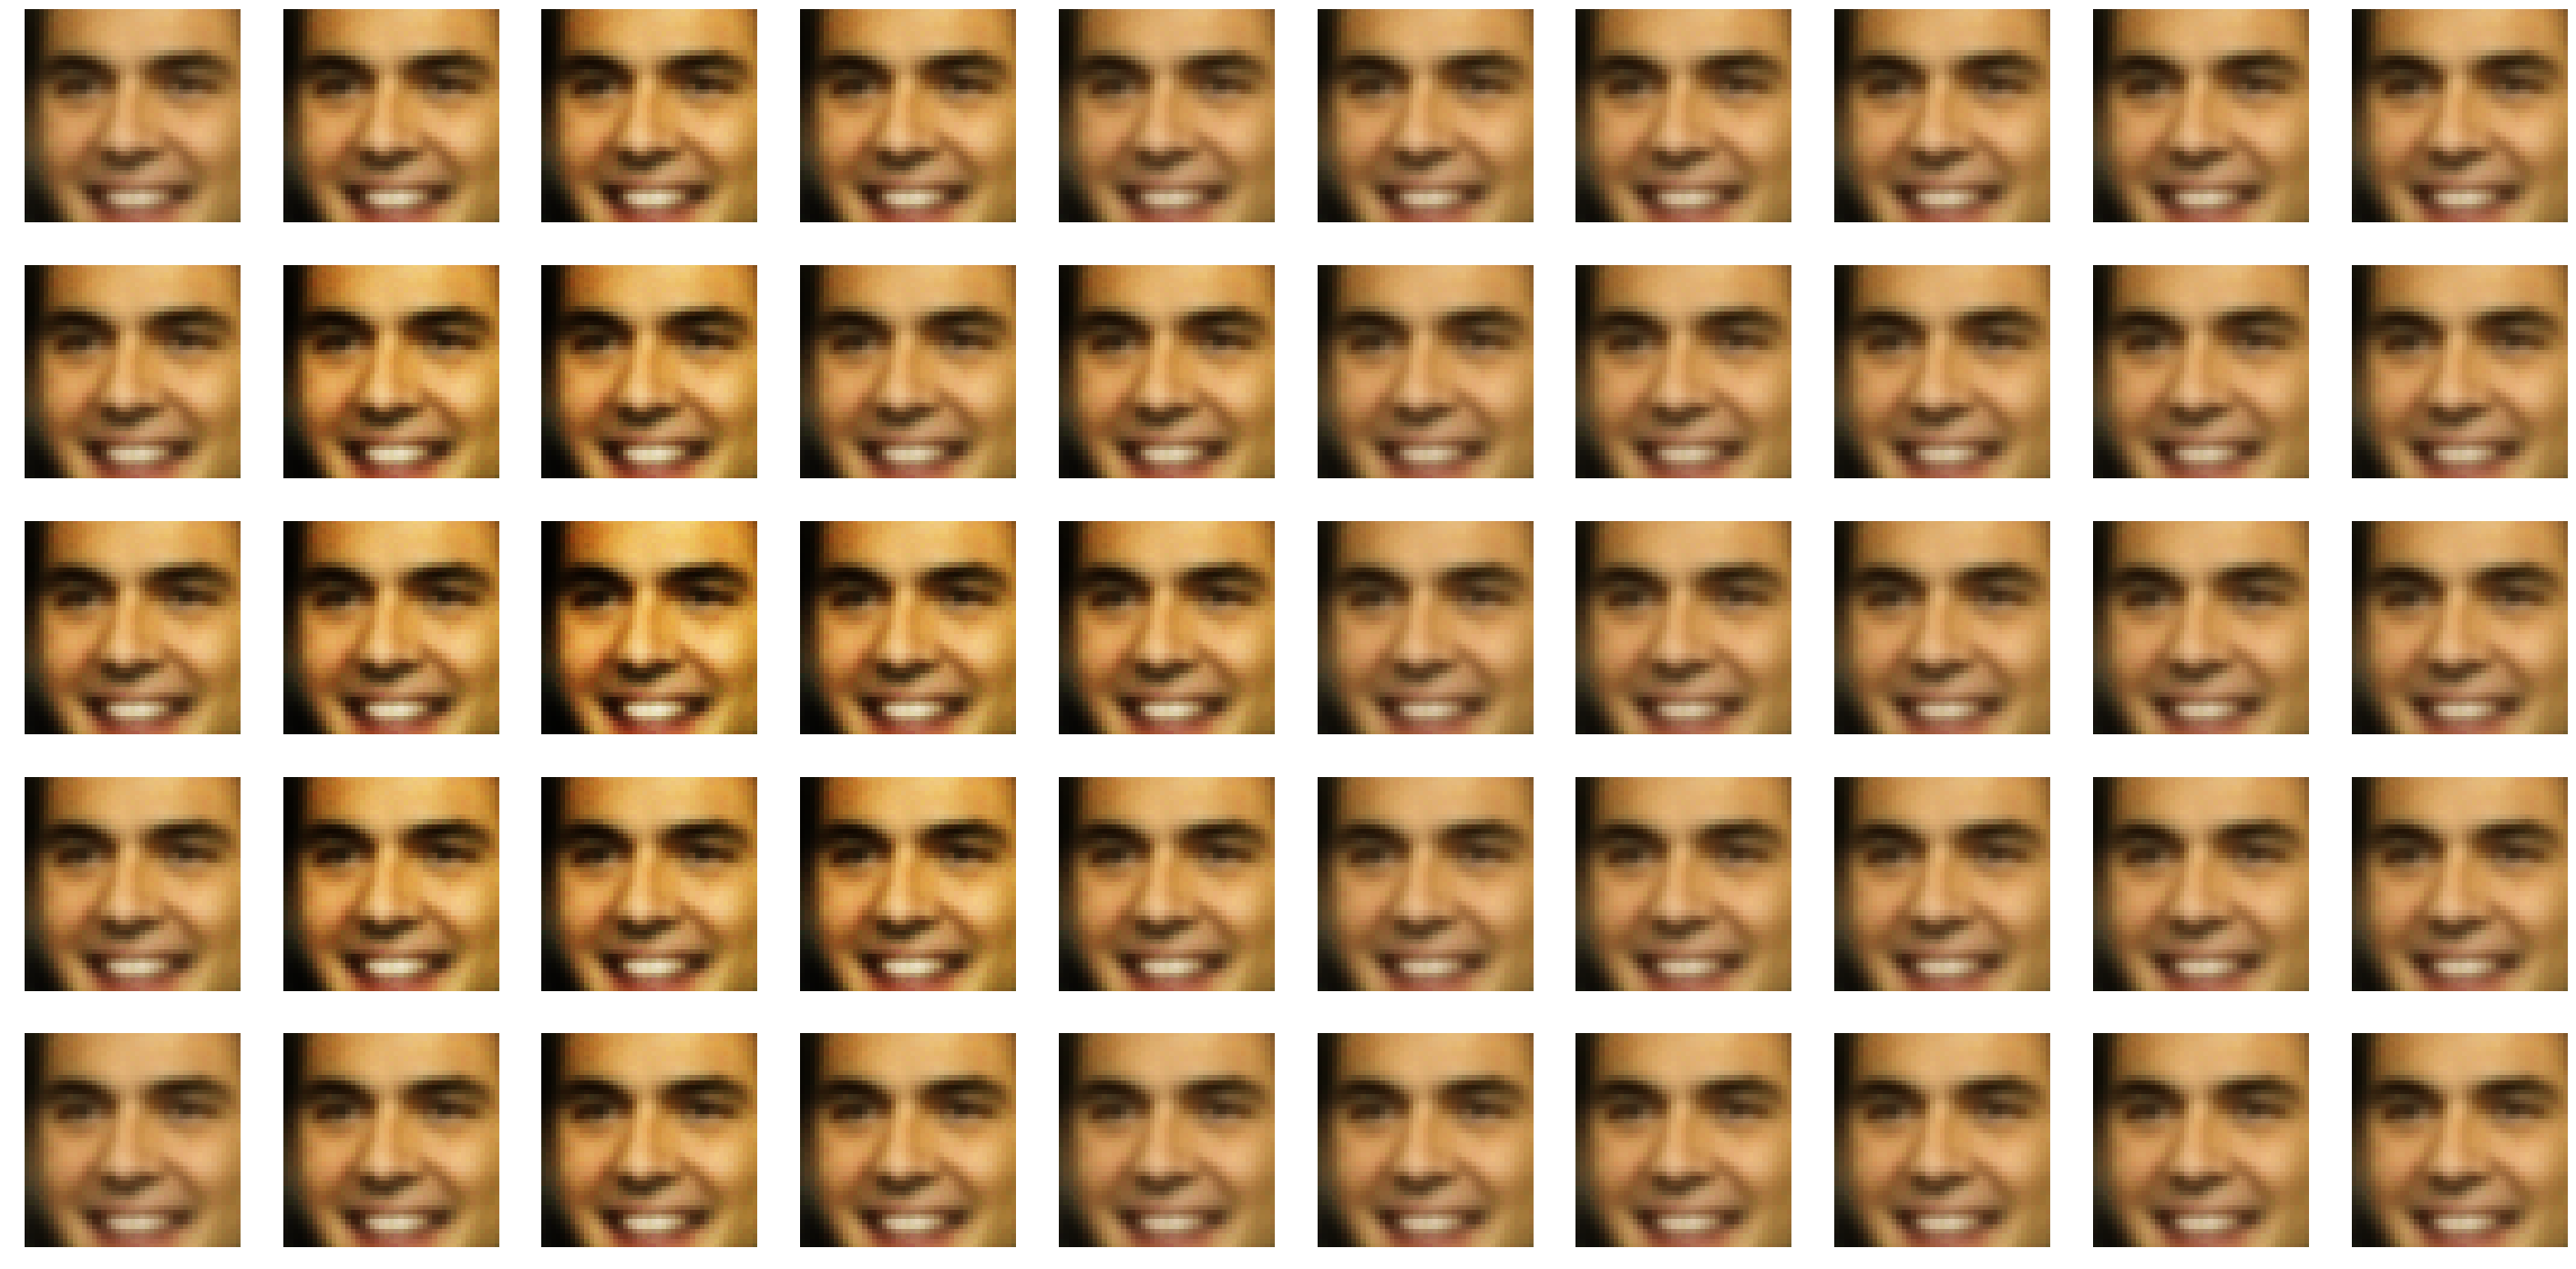

In [70]:
interpolation_4_generation()

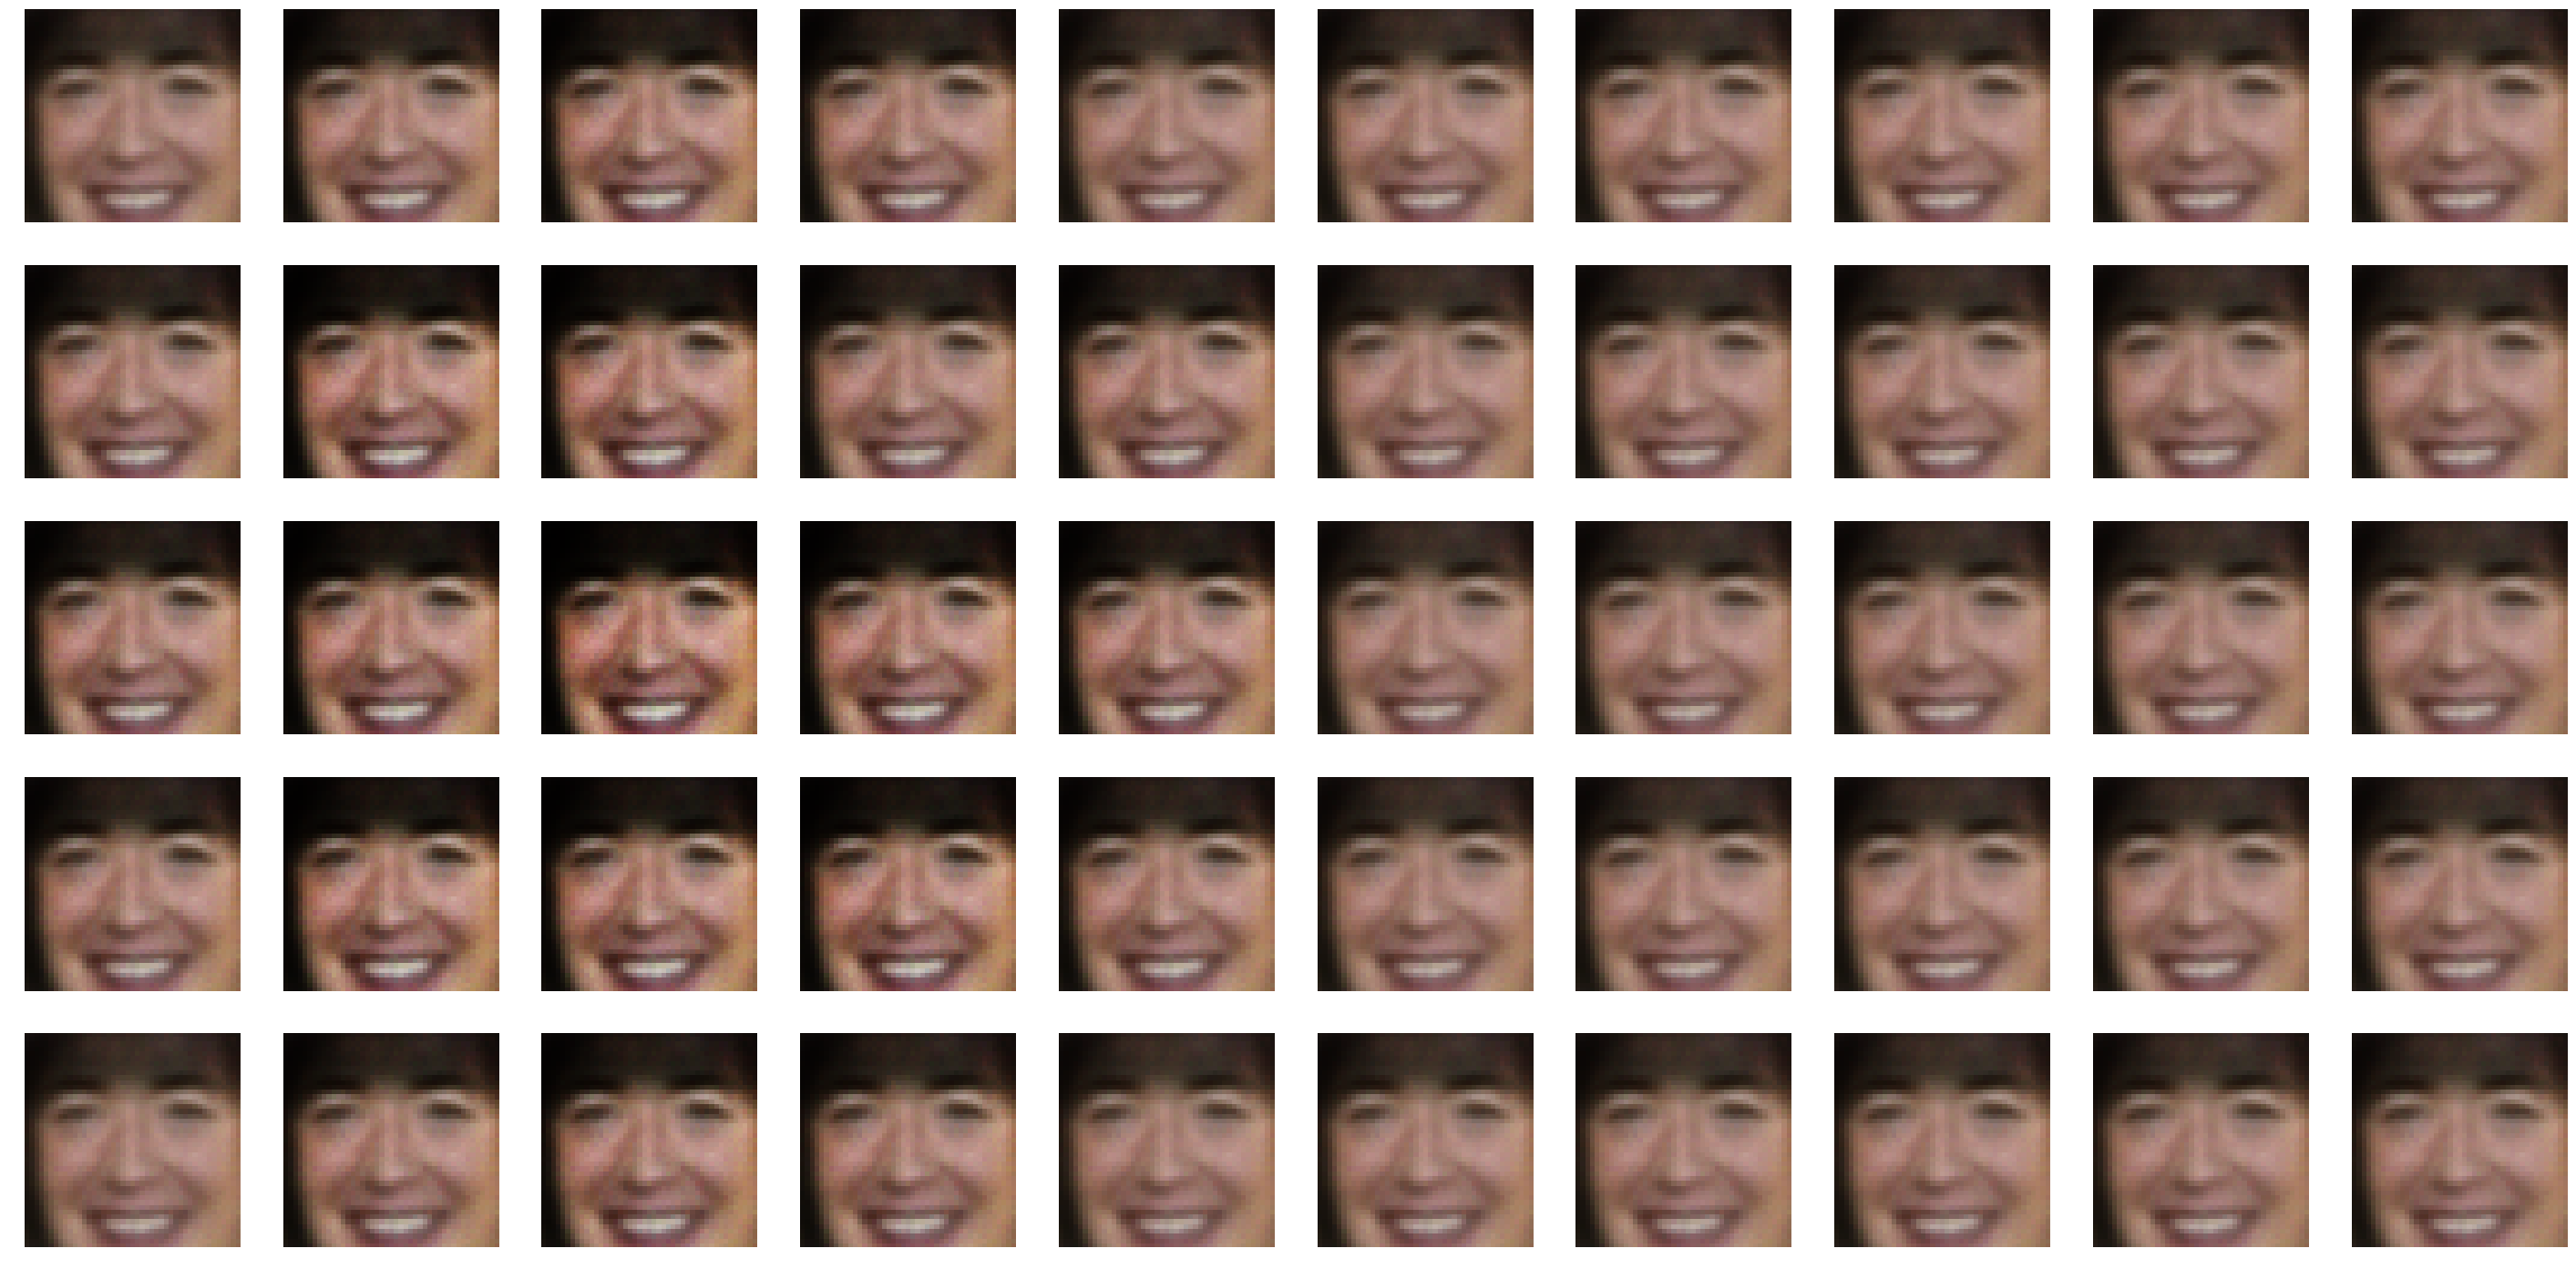

In [72]:
interpolation_4_generation()

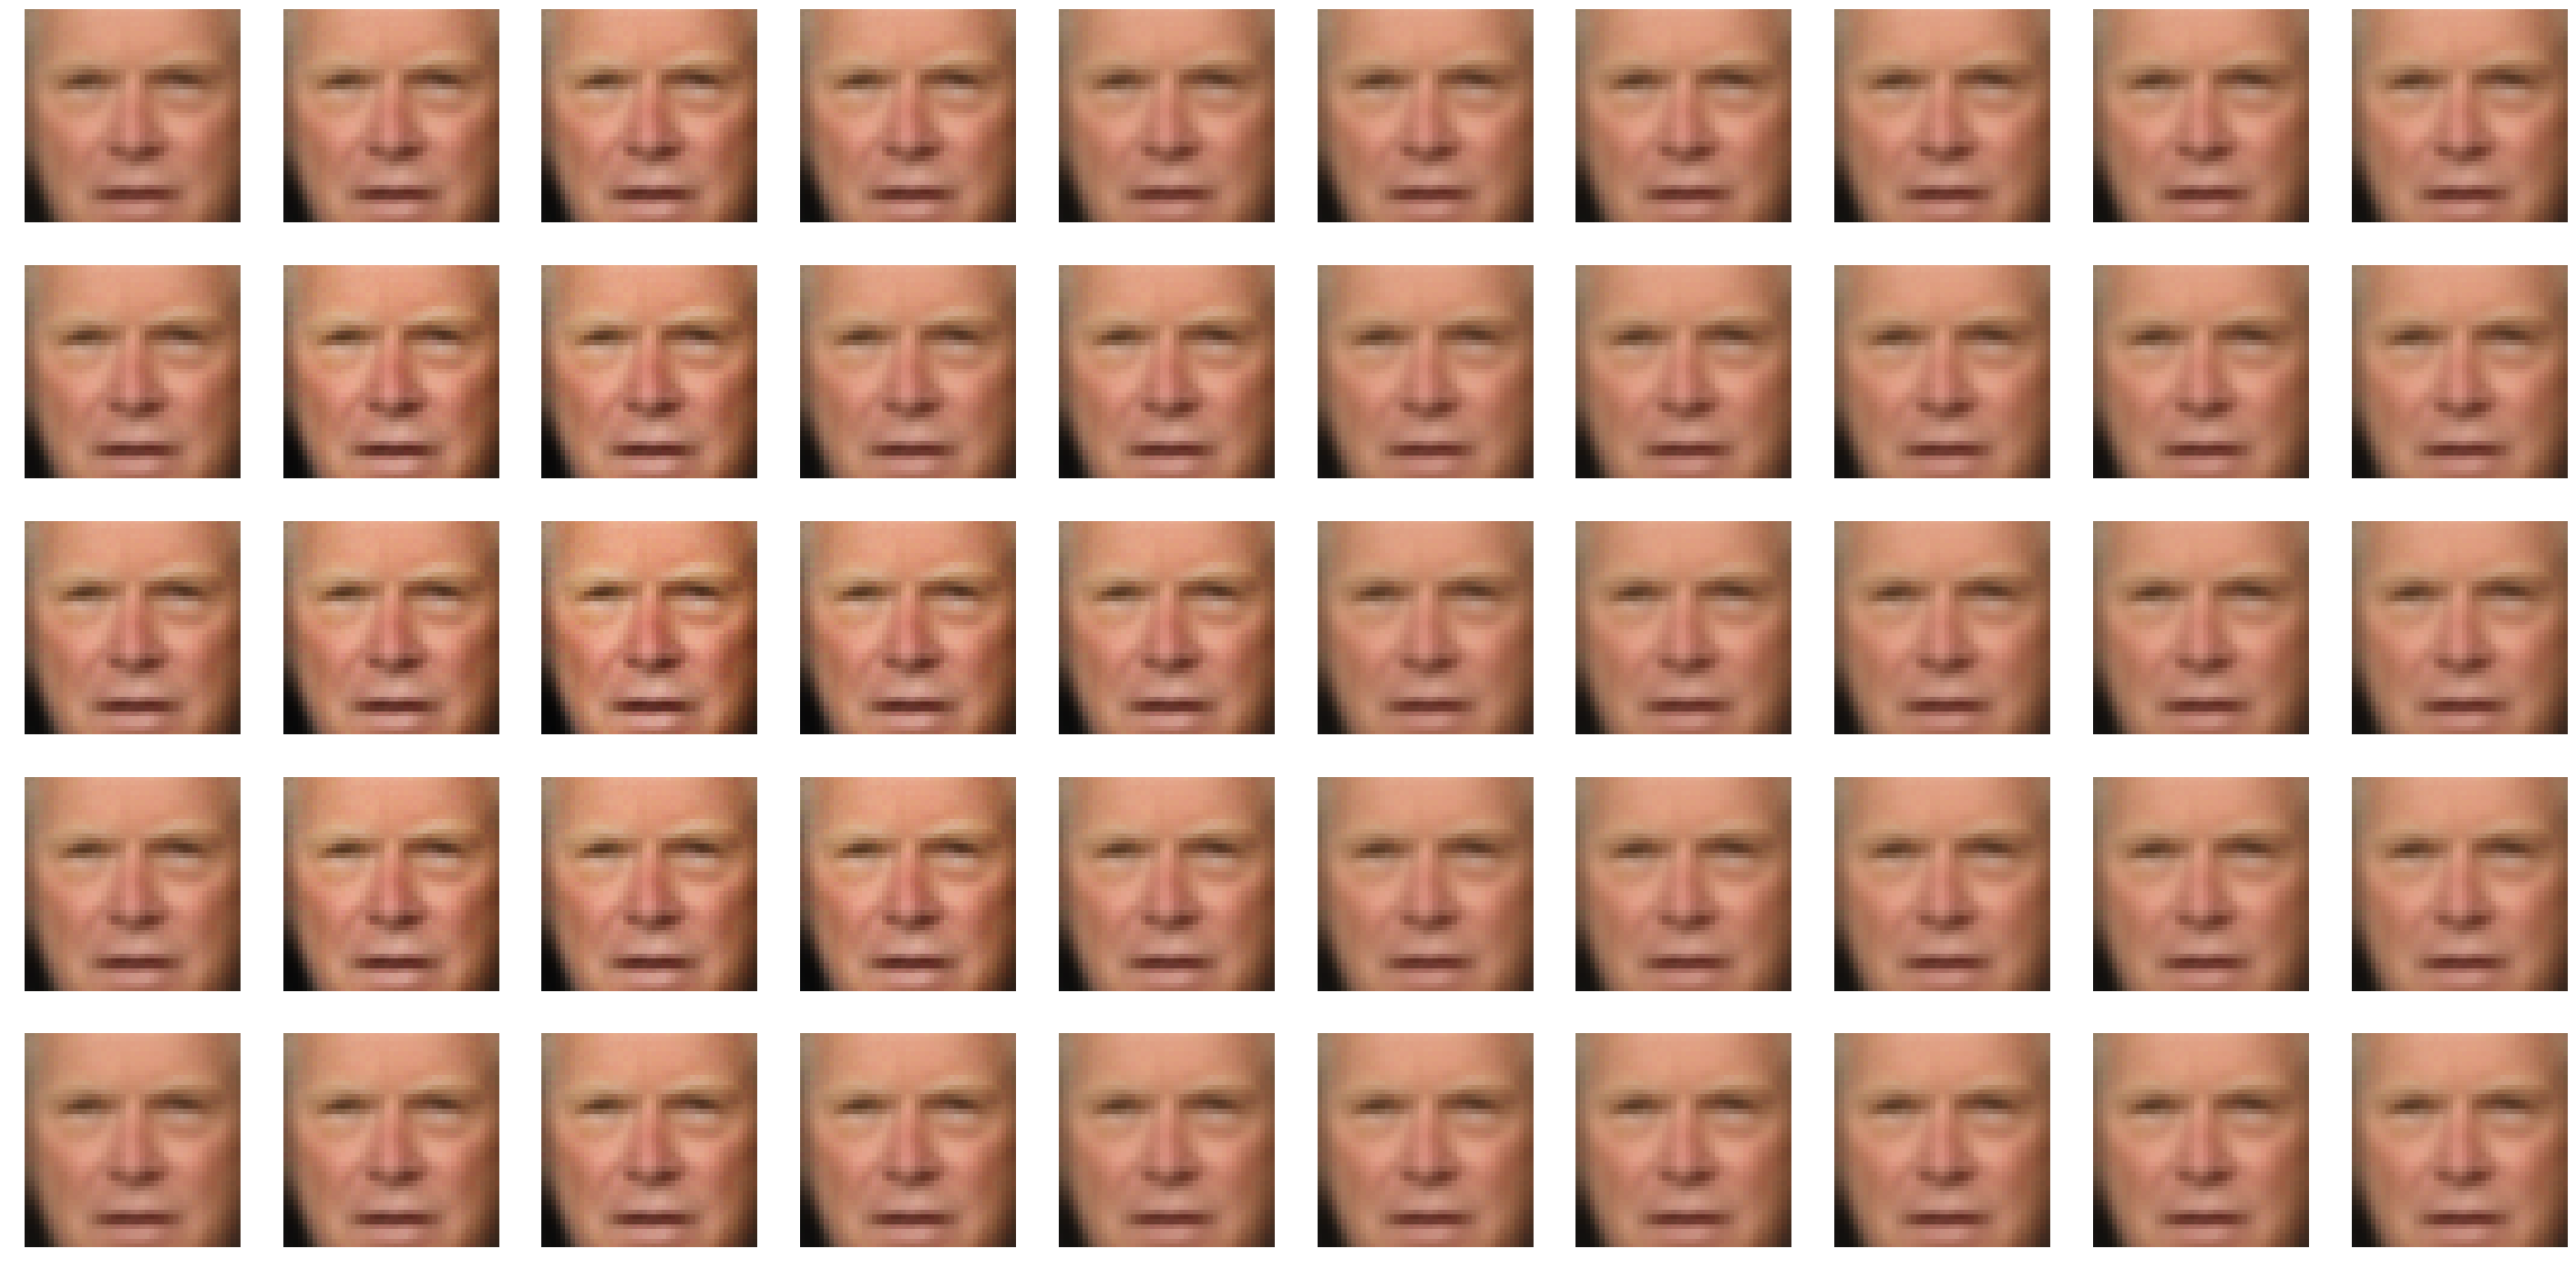

In [73]:
interpolation_4_generation()

### Random walk

In [6]:
from IPython.core.debugger import set_trace

In [19]:
def rw_sample_sequence(n = 10, eps = 0.5):
    rand = torch.randn(dimZ, requires_grad=True)
    rand_shifted_no_scale = vicinity_sampling(rand, torch.zeros_like(rand), eps=eps, do_scale=False).view(1,100)
    rand_shifted = vicinity_sampling(rand, torch.zeros_like(rand), eps=eps).view(1,100)
#     set_trace()
    fig, ax = plt.subplots(nrows=2, ncols=n, figsize=(25,5))
    for i in range(10):
        shift = torch.randn_like(rand_shifted)
        rand_shifted_no_scale = vicinity_sampling(rand_shifted_no_scale, shift, eps=eps, do_scale=False)
        rand_shifted = vicinity_sampling(rand_shifted, shift, eps=eps)
#         set_trace()
        plot_torch_picture(net_VAE.decode(rand_shifted)[0], ax=ax[0,i])
        plot_torch_picture(net_VAE.decode(rand_shifted_no_scale)[0], ax=ax[1,i])
        
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    pass

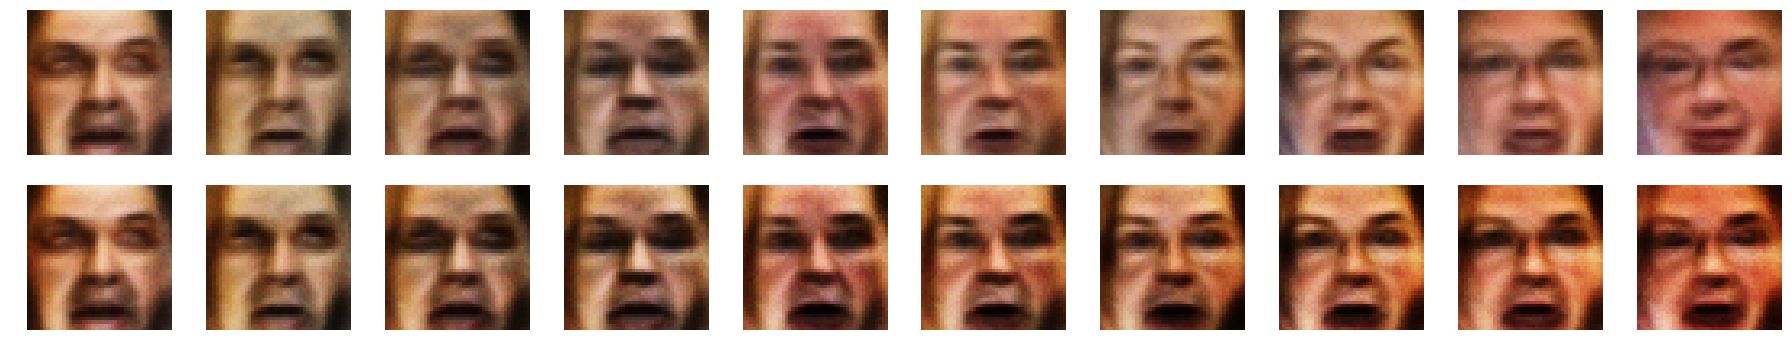

In [21]:
rw_sample_sequence()

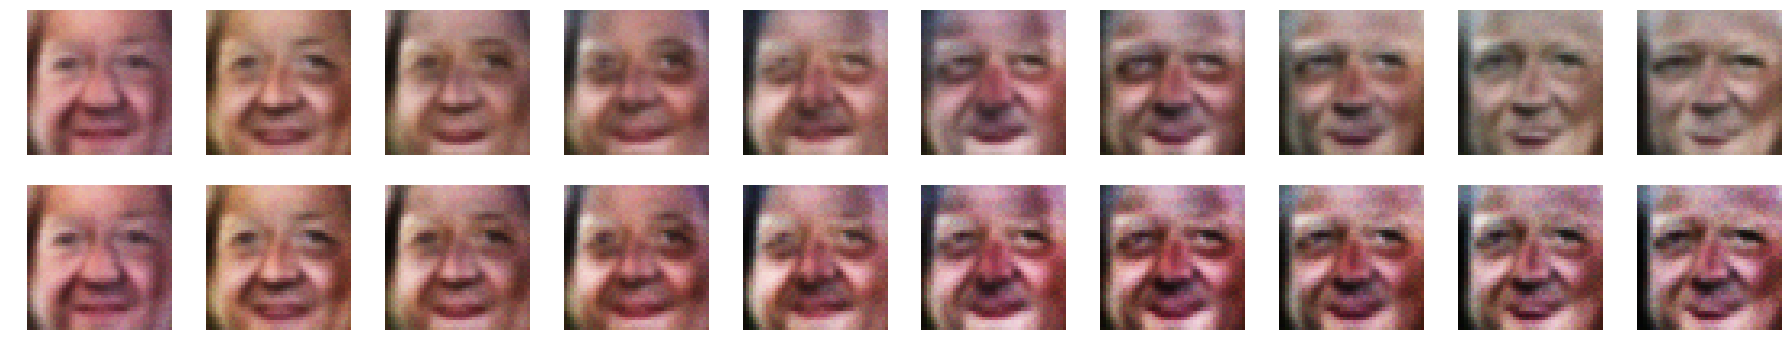

In [23]:
rw_sample_sequence()

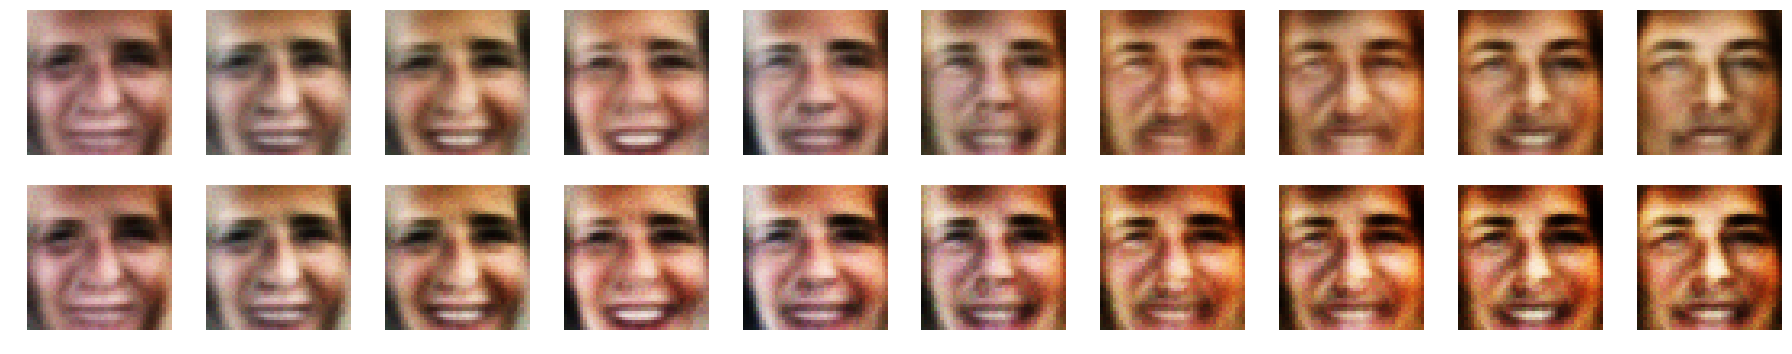

In [25]:
rw_sample_sequence()

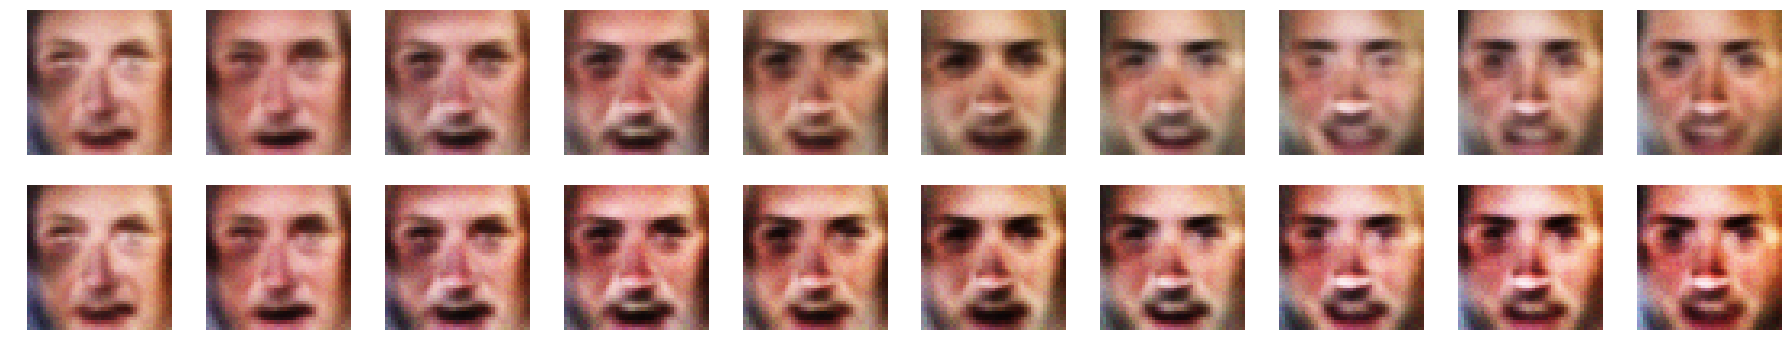

In [31]:
rw_sample_sequence()

# OMFG!